In [1]:
import os
from tvb.simulator.lab import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
LOG = get_logger('demo')
import pickle as cPickle
from tvb.simulator.models.stefanescu_jirsa import ReducedSetHindmarshRose
from os.path import join as pjoin
from sklearn import preprocessing
import scipy.signal as signal

/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/tvb/datatypes/surfaces.py:60: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [48]:
basedir = "/Users/yilewang/Downloads"
only_go = pjoin(basedir, "local_inhibition_only_go")
only_gc = pjoin(basedir, "local_inhibition_only_gc")
go_K21 = pjoin(basedir, "local_inhibition_go_K21")
gc_K21 = pjoin(basedir, "local_inhibition_gc_K21")

In [57]:
# generate a sos bandpass filter function
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs # nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    sos = signal.butter(order, [low, high], analog=False, btype="band", output="sos")
    return sos

def detect_frequency(file, type, group, caseid):
    lfp_data = np.load(file) # a npy file
    # detect spikes using scipy.signal.find_peaks
    peaks_l, _ = signal.find_peaks(lfp_data[8192:, 0, 4, 0], prominence=1)
    # calculate frequency
    freq_l_gamma = len(peaks_l) / 10
    peaks_r, _ = signal.find_peaks(lfp_data[8192:, 0, 5, 0], prominence=1)
    freq_r_gamma = len(peaks_r) / 10

    # conduct signal downsample first
    lfp_data_down_l = signal.decimate(lfp_data[8192:,0,4,0], 100, axis=0, zero_phase=True)
    lfp_data_down_r = signal.decimate(lfp_data[8192:,0,5,0], 100, axis=0, zero_phase=True)
    # then bandpass filter
    sos = butter_bandpass(2, 10, 81920/100)
    lfp_data_filtered_l = signal.sosfiltfilt(sos, lfp_data_down_l)
    lfp_data_filtered_r = signal.sosfiltfilt(sos, lfp_data_down_r)

    # detect spikes using scipy.signal.find_peaks
    peaks_filtered_l, _ = signal.find_peaks(lfp_data_filtered_l, prominence=0.2)
    peaks_filtered_r, _ = signal.find_peaks(lfp_data_filtered_r, prominence=0.2)

    # calculate frequency
    freq_l_theta = len(peaks_filtered_l) / 10
    freq_r_theta = len(peaks_filtered_r) / 10
    figure = plt.figure(figsize=(10, 5))
    ax1 = figure.add_subplot(2, 1, 1)
    ax1.plot(lfp_data[8192:, 0, 4, 0], label="left")
    ax1.plot(lfp_data[8192:, 0, 5, 0], label="right")
    ax1.plot(peaks_l, lfp_data[peaks_l, 0, 4, 0], "x")
    ax1.plot(peaks_r, lfp_data[peaks_r, 0, 5, 0], "x")
    ax1.legend()
    ax2 = figure.add_subplot(2, 1, 2)
    ax2.plot(lfp_data_filtered_l, label="left_filtered")
    ax2.plot(lfp_data_filtered_r, label="right_filtered")
    ax2.plot(peaks_filtered_l, lfp_data_filtered_l[peaks_filtered_l], "x")
    ax2.plot(peaks_filtered_r, lfp_data_filtered_r[peaks_filtered_r], "x")
    ax2.legend()
    plt.title(f"{type}_{group}_{caseid}")
    plt.savefig(f"/Users/yilewang/Desktop/{type}/{group}_{caseid}.png")
    plt.close()
    return freq_l_gamma, freq_r_gamma, freq_l_theta, freq_r_theta

def lateralization_index(freq_l, freq_r):
    if freq_l + freq_r == 0:
        return 0
    else:
        return np.abs(freq_l - freq_r) / (freq_l + freq_r)

In [53]:
# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')
# read k21.txt save as variable k21
K21 = np.loadtxt(f'/Users/yilewang/workspaces/tvbdemos/clinical_conversion/local_inhibition_lfp/K21.txt', dtype=float)

In [58]:

# create a dataframe for all subjects
local_inhibition = pd.DataFrame(columns=['group', 'caseid', 
                                        'gamma_l_go', 'gamma_r_go', 'theta_l_go', 'theta_r_go',
                                        'gamma_l_go_K21', 'gamma_r_go_K21', 'theta_l_go_K21', 'theta_r_go_K21',
                                        'gamma_l_gc', 'gamma_r_gc', 'theta_l_gc', 'theta_r_gc',
                                        'gamma_l_gc_K21', 'gamma_r_gc_K21', 'theta_l_gc_K21', 'theta_r_gc_K21',
                                        'gamma_go_la', 'theta_go_la', 'gamma_go_K21_la', 'theta_go_K21_la',
                                        'gamma_gc_la', 'theta_gc_la', 'gamma_gc_K21_la', 'theta_gc_K21_la'])
for case, gr, gc, go, k21 in zip(mega_data.caseid, mega_data.group, mega_data.Gc, mega_data.Go, K21):
    # read from local_inhibition_only_go
    file_go = pjoin(only_go, gr, f'{case}_{go}.npy')
    freq_l_gamma_go, freq_r_gamma_go, freq_l_theta_go, freq_r_theta_go = detect_frequency(file_go, 'only_go', gr, case)
    freq_gamma_go_la =  lateralization_index(freq_l_gamma_go, freq_r_gamma_go)
    freq_theta_go_la = lateralization_index(freq_l_theta_go, freq_r_theta_go)
    # read from local_inhibition_go_K21
    file_go_K21 = pjoin(go_K21, gr, f'{case}_go_{go}.npy')
    freq_l_gamma_go_K21, freq_r_gamma_go_K21, freq_l_theta_go_K21, freq_r_theta_go_K21 = detect_frequency(file_go_K21, 'go_K21', gr, case)
    freq_gamma_go_K21_la =  lateralization_index(freq_l_gamma_go_K21, freq_r_gamma_go_K21)
    freq_theta_go_K21_la = lateralization_index(freq_l_theta_go_K21, freq_r_theta_go_K21)
    # read from local_inhibition_only_gc
    file_gc = pjoin(only_gc, gr, f'{case}_{gc}.npy')
    freq_l_gamma_gc, freq_r_gamma_gc, freq_l_theta_gc, freq_r_theta_gc = detect_frequency(file_gc, 'only_gc', gr, case)
    freq_gamma_gc_la =  lateralization_index(freq_l_gamma_gc, freq_r_gamma_gc)
    freq_theta_gc_la = lateralization_index(freq_l_theta_gc, freq_r_theta_gc)
    # read from local_inhibition_gc_K21
    file_gc_K21 = pjoin(gc_K21, gr, f'{case}_{k21}.npy')
    freq_l_gamma_gc_K21, freq_r_gamma_gc_K21, freq_l_theta_gc_K21, freq_r_theta_gc_K21 = detect_frequency(file_gc_K21, 'gc_K21', gr, case)
    freq_gamma_gc_K21_la =  lateralization_index(freq_l_gamma_gc_K21, freq_r_gamma_gc_K21)
    freq_theta_gc_K21_la = lateralization_index(freq_l_theta_gc_K21, freq_r_theta_gc_K21)

    # concate all variables to a dataframe
    local_inhibition = pd.concat([local_inhibition, pd.DataFrame({'group':gr, 'caseid':case, 
                                        'gamma_l_go': freq_l_gamma_go, 'gamma_r_go':freq_r_gamma_go, 
                                        'theta_l_go':freq_l_theta_go, 'theta_r_go':freq_r_theta_go,
                                        'gamma_l_go_K21':freq_l_gamma_go_K21, 'gamma_r_go_K21':freq_r_gamma_go_K21, 'theta_l_go_K21':freq_l_theta_go_K21, 'theta_r_go_K21':freq_r_theta_go_K21,
                                        'gamma_l_gc':freq_l_gamma_gc, 'gamma_r_gc':freq_r_gamma_gc, 'theta_l_gc':freq_l_theta_gc, 'theta_r_gc':freq_r_theta_gc,
                                        'gamma_l_gc_K21':freq_l_gamma_gc_K21, 'gamma_r_gc_K21':freq_l_gamma_gc_K21, 'theta_l_gc_K21':freq_l_theta_gc_K21, 'theta_r_gc_K21':freq_r_theta_gc_K21,
                                        'gamma_go_la':freq_gamma_go_la, 'theta_go_la':freq_theta_go_la, 'gamma_go_K21_la':freq_gamma_go_K21_la, 'theta_go_K21_la':freq_theta_go_K21_la,
                                        'gamma_gc_la':freq_gamma_gc_la, 'theta_gc_la':freq_theta_gc_la, 'gamma_gc_K21_la':freq_gamma_gc_K21_la, 'theta_gc_K21_la':freq_theta_gc_K21_la}, index=[0])], axis=0)

    print(local_inhibition)



  group caseid  gamma_l_go  gamma_r_go  theta_l_go  theta_r_go  \
0   SNC  2820A         2.8        28.2         4.9         6.4   

   gamma_l_go_K21  gamma_r_go_K21  theta_l_go_K21  theta_r_go_K21  ...  \
0             2.4            29.9             5.1             6.6  ...   

   theta_l_gc_K21  theta_r_gc_K21  gamma_go_la  theta_go_la  gamma_go_K21_la  \
0             5.2             6.2     0.819355     0.132743         0.851393   

   theta_go_K21_la  gamma_gc_la  theta_gc_la  gamma_gc_K21_la  theta_gc_K21_la  
0         0.128205      0.63587     0.135593         0.568421         0.087719  

[1 rows x 26 columns]
  group caseid  gamma_l_go  gamma_r_go  theta_l_go  theta_r_go  \
0   SNC  2820A         2.8        28.2         4.9         6.4   
0   SNC  3168A         0.0        22.0         0.0         6.3   

   gamma_l_go_K21  gamma_r_go_K21  theta_l_go_K21  theta_r_go_K21  ...  \
0             2.4            29.9             5.1             6.6  ...   
0             0.0        

In [59]:
local_inhibition.to_csv('/Users/yilewang/Desktop/local_inhibition_lfp4types.csv')

In [68]:
import sys
# sys.path.append('/Users/yilewang/workspaces/')
from tvbtools.tools import statools

sign_table = statools.stats_calculator(local_inhibition, tails="greater")
sign_table.to_csv('/Users/yilewang/Desktop/local_inhibition_lfp4types_sign_table.csv')

In [3]:
local_inhibition = pd.read_csv('/Users/yilewang/Desktop/LFP_4conditions_data_table.csv')

gamma_frequency_left_gc
gamma_frequency_left_gc_K21
gamma_frequency_right_gc
gamma_frequency_right_gc_K21
theta_frequency_left_gc
theta_frequency_left_gc_K21
theta_frequency_right_gc
theta_frequency_right_gc_K21


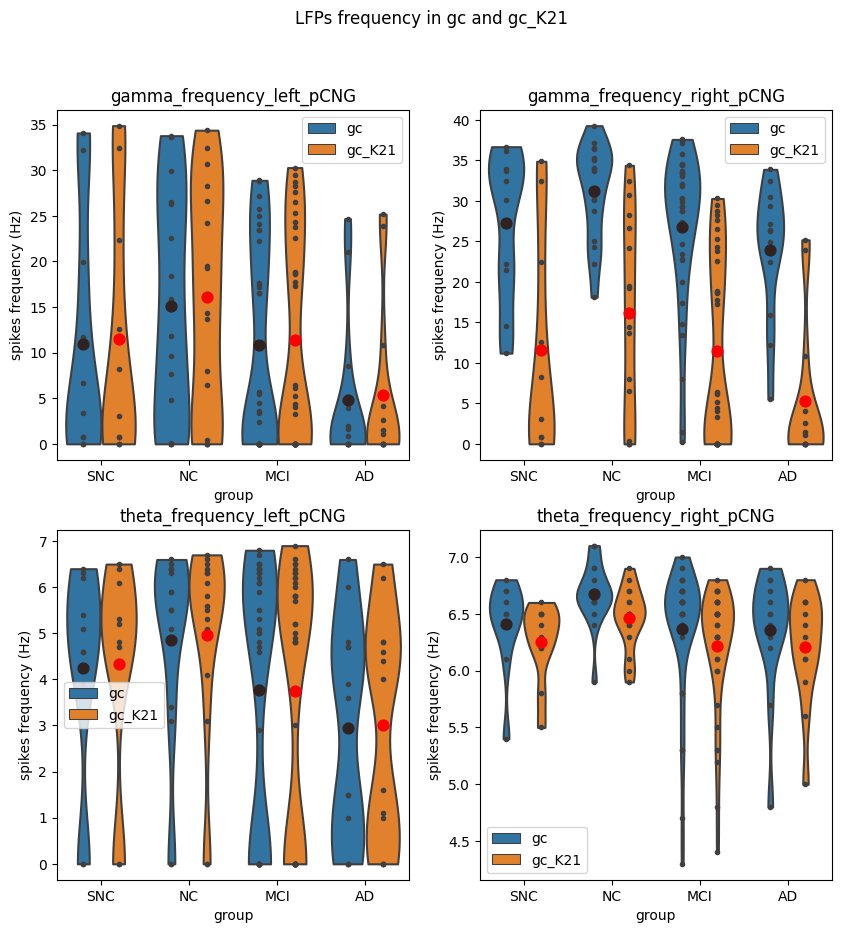

In [64]:
types = 'gc'
# generate a list with first 74 items as "go", and the last 74 items as "go_K21"
parameters = [f'{types}'] * 74 + [f'{types}_K21'] * 74

titles = ["gamma_frequency_left_pCNG", "gamma_frequency_right_pCNG", "theta_frequency_left_pCNG", "theta_frequency_right_pCNG"]
# titles = ["gamma_lateralization", "theta_lateralization"]
figure = plt.figure(figsize=(10, 10))
# set title
figure.suptitle(f"LFPs frequency in {types} and {types}_K21")
for index, i in enumerate(range(8,12)):
    print(local_inhibition.columns[i+2])
    print(local_inhibition.columns[i+6])
    # concate local_inhibition.gamma_l_go and local_inhibition.gamma_l_go_K21
    y_data = pd.concat([local_inhibition.iloc[:,i+2], local_inhibition.iloc[:,i+6]], axis=0)
    group_concat = pd.concat([local_inhibition.group, local_inhibition.group], axis=0)

    # plot violinplot
    ax1 = figure.add_subplot(2, 2, index+1)

    sns.violinplot(x=group_concat, y=y_data, hue=parameters, cut=0, bw=.4, ax=ax1, inner="point")
    sns.pointplot(x=group_concat, y=y_data, hue=parameters, ax=ax1, dodge=.4, markers="o", color="red", errorbar=None, linestyles="none",label=None)
    ax1.set_ylabel("spikes frequency (Hz)")
    # sns.stripplot(x=group_concat, y=y_data, hue=parameters, dodge = True, ax=ax1)
    ax1.set_title(titles[index])
    # remove legend of pointplot
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[:2], labels[:2])
plt.show()



gamma_frequency_lateralization_go
gamma_frequency_lateralization_go_K21
theta_frequency_lateralization_go
theta_frequency_lateralization_go_K21


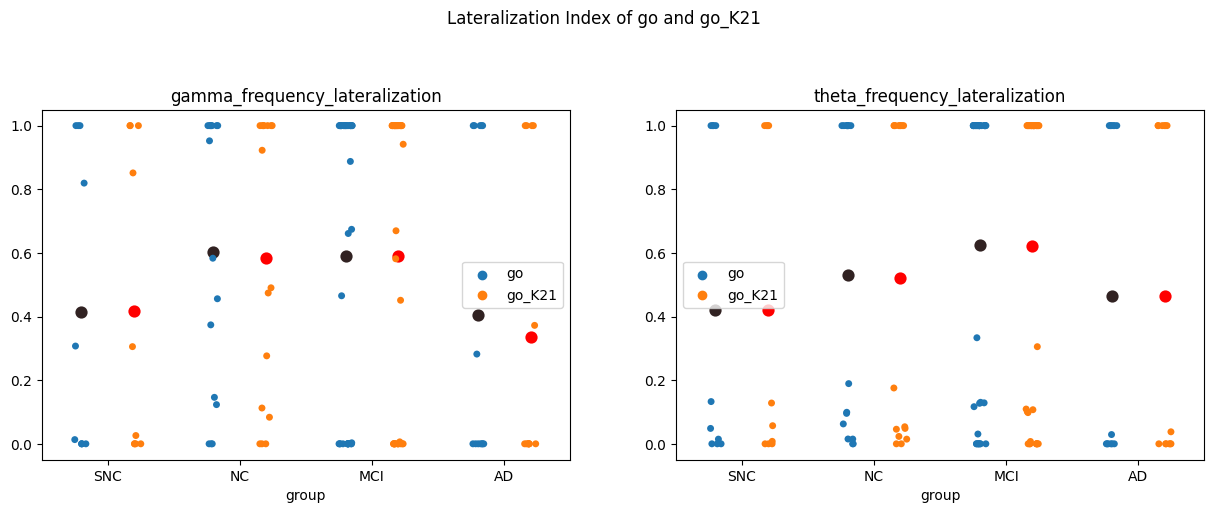

In [65]:
types = 'go'
# generate a list with first 74 items as "go", and the last 74 items as "go_K21"
parameters = [f'{types}'] * 74 + [f'{types}_K21'] * 74

# titles = ["gamma_left", "gamma_right", "theta_left", "theta_right"]
titles = ["gamma_frequency_lateralization", "theta_frequency_lateralization"]
figure = plt.figure(figsize=(15, 10))
figure.suptitle(f"Lateralization Index of {types} and {types}_K21")
for index, i in enumerate(range(16,18)):
    print(local_inhibition.columns[i+2])
    print(local_inhibition.columns[i+4])
    # concate local_inhibition.gamma_l_go and local_inhibition.gamma_l_go_K21
    y_data = pd.concat([local_inhibition.iloc[:,i+2], local_inhibition.iloc[:,i+4]], axis=0)
    group_concat = pd.concat([local_inhibition.group, local_inhibition.group], axis=0)

    # plot violinplot
    ax1 = figure.add_subplot(2, 2, index+1)
    # sns.violinplot(x=group_concat, y=y_data, hue=parameters, cut=0, bw=.4, ax=ax1)
    sns.stripplot(x=group_concat, y=y_data, hue=parameters, dodge = True, ax=ax1)
    # plot mean point using red dot with error bar
    sns.pointplot(x=group_concat, y=y_data, hue=parameters, ax=ax1, dodge=.4, markers="o", color="red", errorbar=None, linestyles="none")
    ax1.set_title(titles[index])
    # remove legend of pointplot
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[:2], labels[:2])
plt.show()

In [ ]:
# for case, gr, gc, go, k21 in zip(mega_data.caseid, mega_data.group, mega_data.Gc, mega_data.Go, K21):
#     # read from local_inhibition_only_go
#     file_go = pjoin(only_go, gr, f'{case}_{go}.npy')
#     freq_l_go, freq_r_go = detect_frequency(file_go, gr, case, 'only_go')
#     # read from local_inhibition_only_gc
#     file_gc = pjoin(only_gc, gr, f'{case}_{gc}.npy')
#     freq_l_gc, freq_r_gc = detect_frequency(file_gc, gr, case, 'only_gc')

#     # read from local_inhibition_go_K21
#     file_go_K21 = pjoin(go_K21, gr, f'{case}_go_{go}.npy')
#     freq_l_go_K21, freq_r_go_K21 = detect_frequency(file_go_K21, gr, case, 'go_K21')

#     # read from local_inhibition_gc_K21
#     file_gc_K21 = pjoin(gc_K21, gr, f'{case}_{k21}.npy')
#     freq_l_gc_K21, freq_r_gc_K21 = detect_frequency(file_gc_K21, gr, case, 'gc_K21')


In [ ]:
local_inhibition = pd.read_excel('/Users/yilewang/Desktop/local_inhibition.xlsx', sheet_name='go')
figure = plt.figure(figsize=(10, 5))
# plot two violin plots
sns.violinplot(x="group", y="freq_l_go", hue="local", data=local_inhibition,cut=0, bw=.4)
plt.show()
sns.violinplot(x="group", y="freq_r_go", hue="local", data=local_inhibition,cut=0, bw=.4)
plt.show()
sns.violinplot(x="group", y="la_go", hue="local", data=local_inhibition,cut=0, bw=.4)

In [ ]:
# sys.path.append('/Users/yilewang/workspaces/tvbtools')

The P-value of the Permutation Test is: 0.004399560043995601


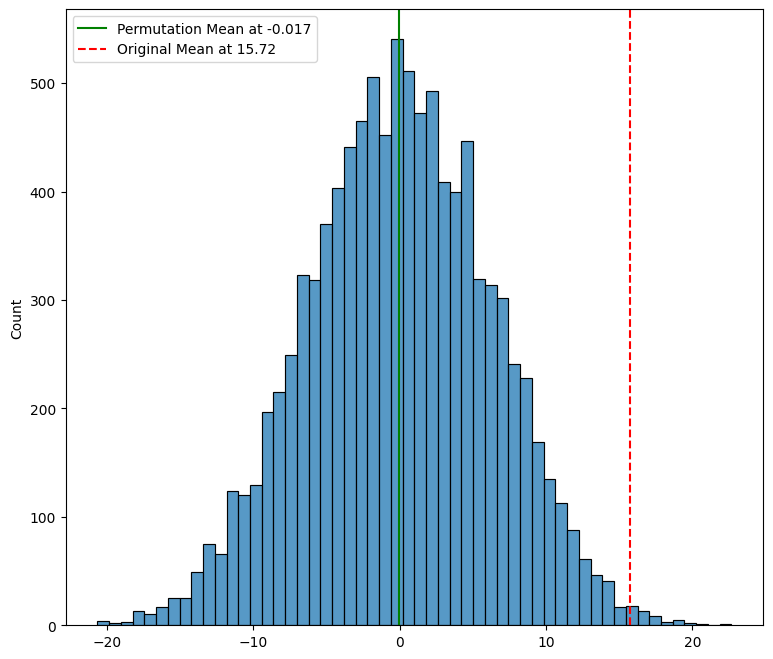

The P-value of the Permutation Test is: 0.00019998000199980003


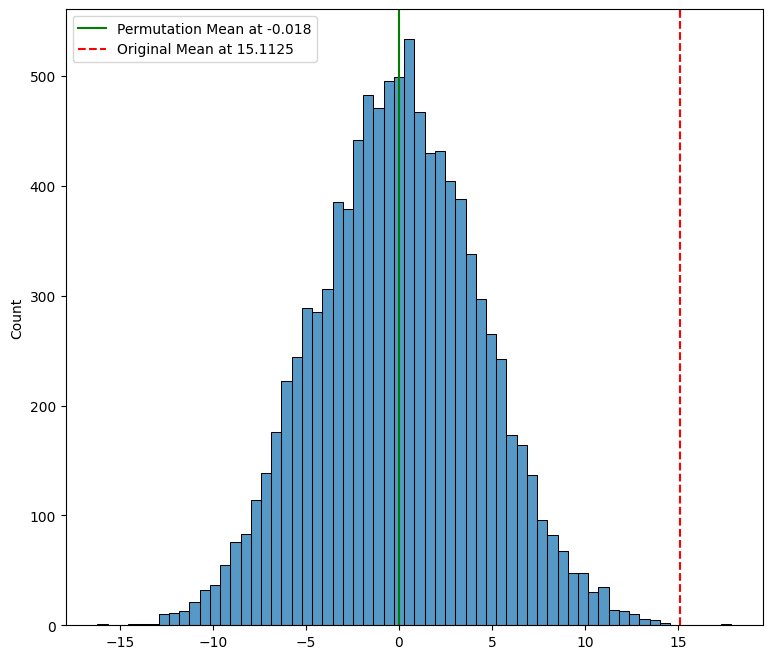

The P-value of the Permutation Test is: 9.999000099990002e-05


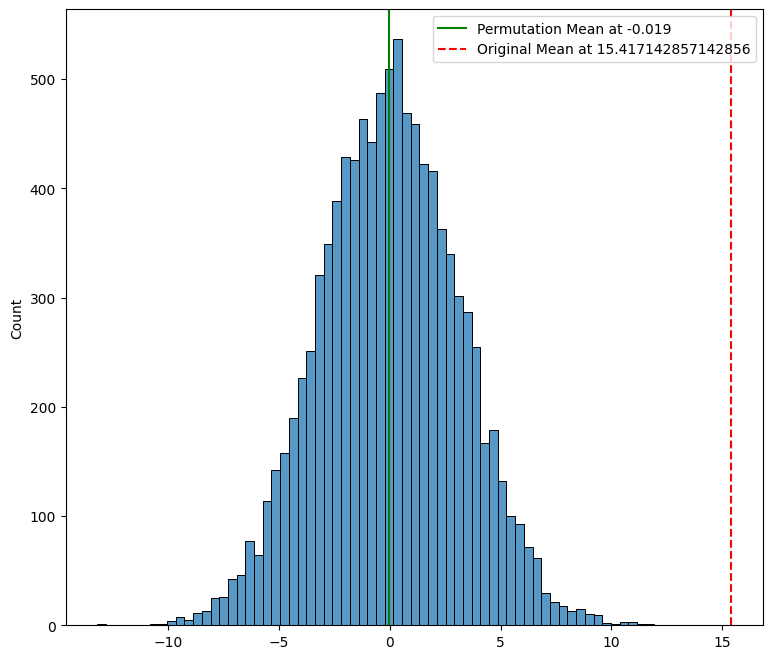

The P-value of the Permutation Test is: 9.999000099990002e-05


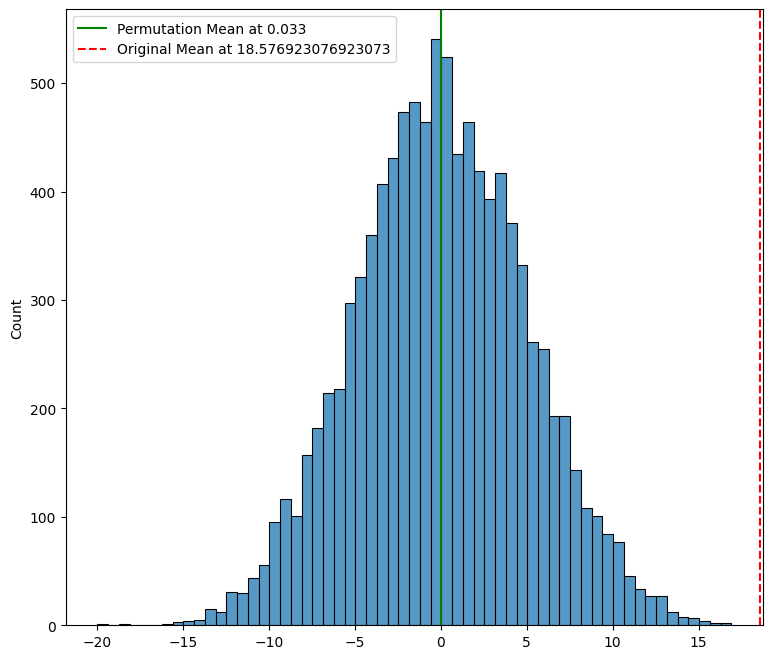

In [67]:
# permutation test, import tvbtools from /Users/yilewang/workspaces/tvbtools
import sys
from tvbtools.tools.statools import permutation_test
groups = ['SNC', 'NC', 'MCI', 'AD']
for i in groups:
    permutation_test(local_inhibition[local_inhibition.group == i].gamma_r_gc, local_inhibition[local_inhibition.group == i].gamma_r_gc_K21, 10000,True)

